# Recreating the `demo_derangments_basic` model from the [work](https://qtechtheory.org/derangement_circuits/) of Balint Koczor
---

In [1]:
from asset_func import *
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

## The circuit
---

### The observable:

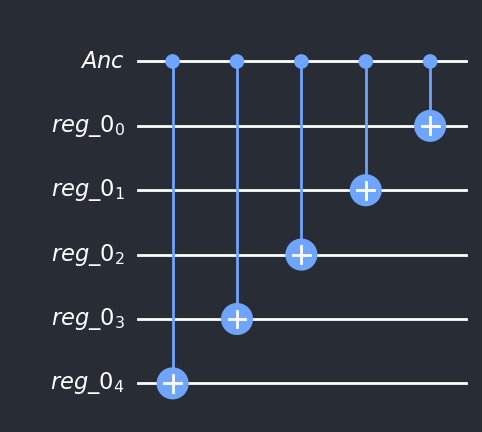

In [2]:
obs = iniQC(1,5,1)
cnots(obs,[0])
obs.draw()

### The full circuit:

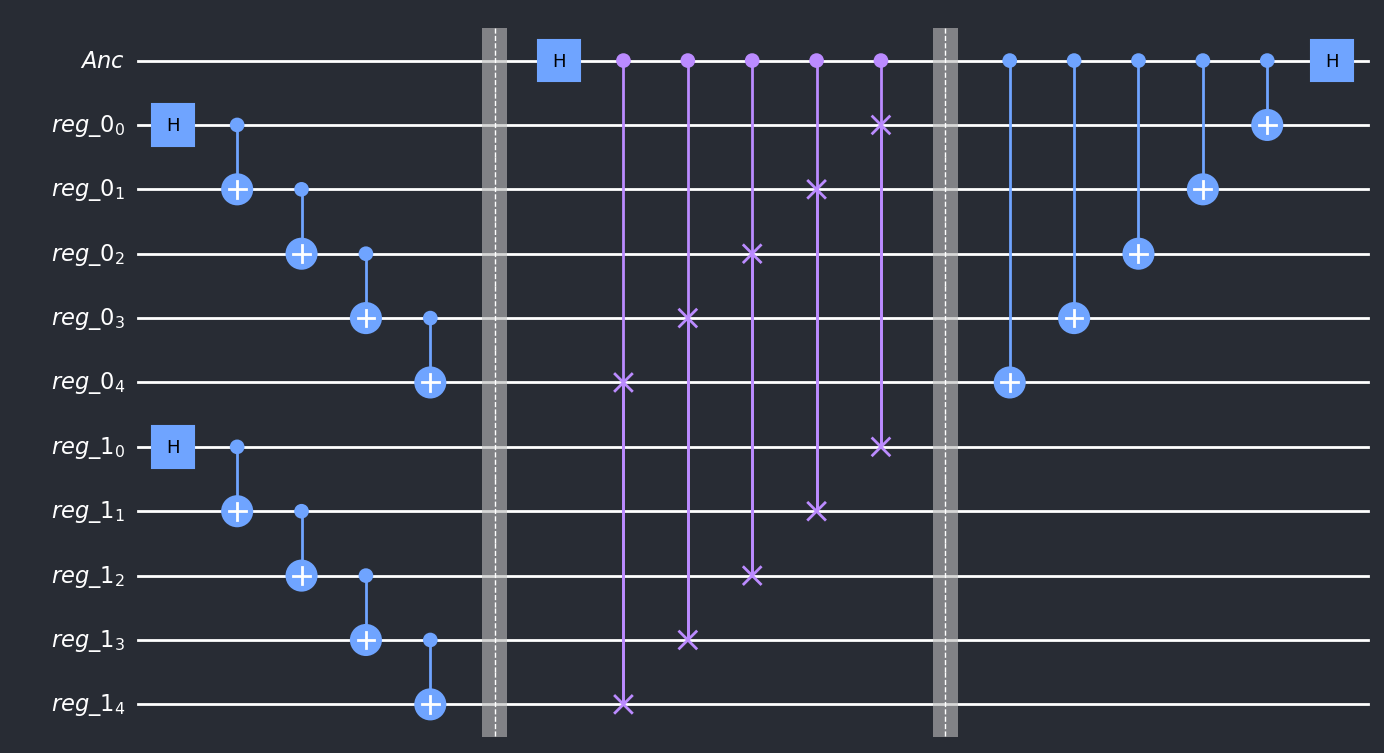

In [4]:
full_qc = circ_assembler(numReg = 2, numQ = 5, numAnc = 1, sigma = obs, 
                         basis_gates = ['cx'], der_op = True)

full_qc.draw()

## Expectation value
---

### Exact expectation value:
The known expectation value of the circuit is $1$. We can also check this using the `circ_tester()` function which returns the expectation value both for the mitigated and unmitigated (circuit without the derangement operator) circuits. 

In [5]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots # we calcualte the expectation value from the density matrix
noise_model = None # we are not applying noise at this point, see later sections

mit, unmit = circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {} and the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 1.0 and the unmitigated is: 1.0.


### Estimated expectation value, with the noise model from the demo:

In the mathematica demo, a depolarizing error with probability $p = 0.01$ is added to after each $CX$ gate of the $\text{GHZ}$ state. Here we reproduce the same noise model and obtain the expectation value first by performing the exact calculation second by estimating it using $10000$ shots.

In order to only apply the depolarizing error to the $CX$ gates for the $\text{GHZ}$ state and not for the observable, we redifine the observable by decomposing it into costum $CX$ gates:

In [6]:
qc = QuantumCircuit(2, name = 'costum_cx')
qc.cx(0,1)
costum_cx = qc.to_gate()

redifining the `cnots` function to use our costum gates:

In [7]:
def cnots(qc, regs):

    """ Applies a cx gate between the Ancilla qubit and each qubit of the selected quantum registers. 
    
    
    Parameters
    ----------
    qc : qiskit quantum circuit
        The circuit to which the cx gates are applied
    regs : int
        The register to which the cx gates are applied to. 
    Returns
    -------
    A qiskit quantum circuit.

    """

    ancilla_qubit = qc.ancillas[0]
    registers = qc.qregs[1:]
    numQubits = registers[0].size

    for reg in regs:
        for qubit in reversed(range(numQubits)):
            qc.append(costum_cx,(ancilla_qubit, registers[reg][qubit])) # <-- redifning here

In [8]:
obs = iniQC(1,5,1)
cnots(obs,[0])
#obs.draw() # uncomment to show redifined observable

In [9]:
full_qc = circ_assembler(numReg = 2, numQ = 5, numAnc = 1, sigma = obs, 
                         basis_gates = ['costum_cx'], der_op = True)

#full_qc.draw(fold = -1) # uncomment to show circuit with costum cx gates

#### Creating the noise model:

In [10]:
error = 0.01 # defining error probability

err_2q = depolarizing_error(error, 2) # 2 qubit error for cx gates in the GHZ state

noise_simple = NoiseModel() # create noise model
noise_simple.add_all_qubit_quantum_error(err_2q, ['cx'])

noise_simple.add_basis_gates(['h', 'cx', 'cswap', 'costum_cx'])

Assigning the noise model to the simulator (one for exact calculation, one for estimation using $100000$ shots):

Finally evaulting the circuit:

In [11]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots # we calcualte the expectation value from the density matrix
noise_model = noise_simple # we are not applying noise at this point, see later sections

mit, unmit = circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {},\nand the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 0.9847405900305188,
and the unmitigated is: 0.9580078125.


In [12]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 100000 # we are interested in the exact (algeabraic) expectation value hence no shots # we calcualte the expectation value from the density matrix
noise_model = noise_simple # we are not applying noise at this point, see later sections

mit, unmit = circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {},\nand the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 0.9770665452927972,
and the unmitigated is: 0.9564900000000001.
